In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Check a few random images 


1237661351632306326.npy
1237662528451051627.npy
1237667252923596845.npy
1237667108500996316.npy
1237654880205275427.npy


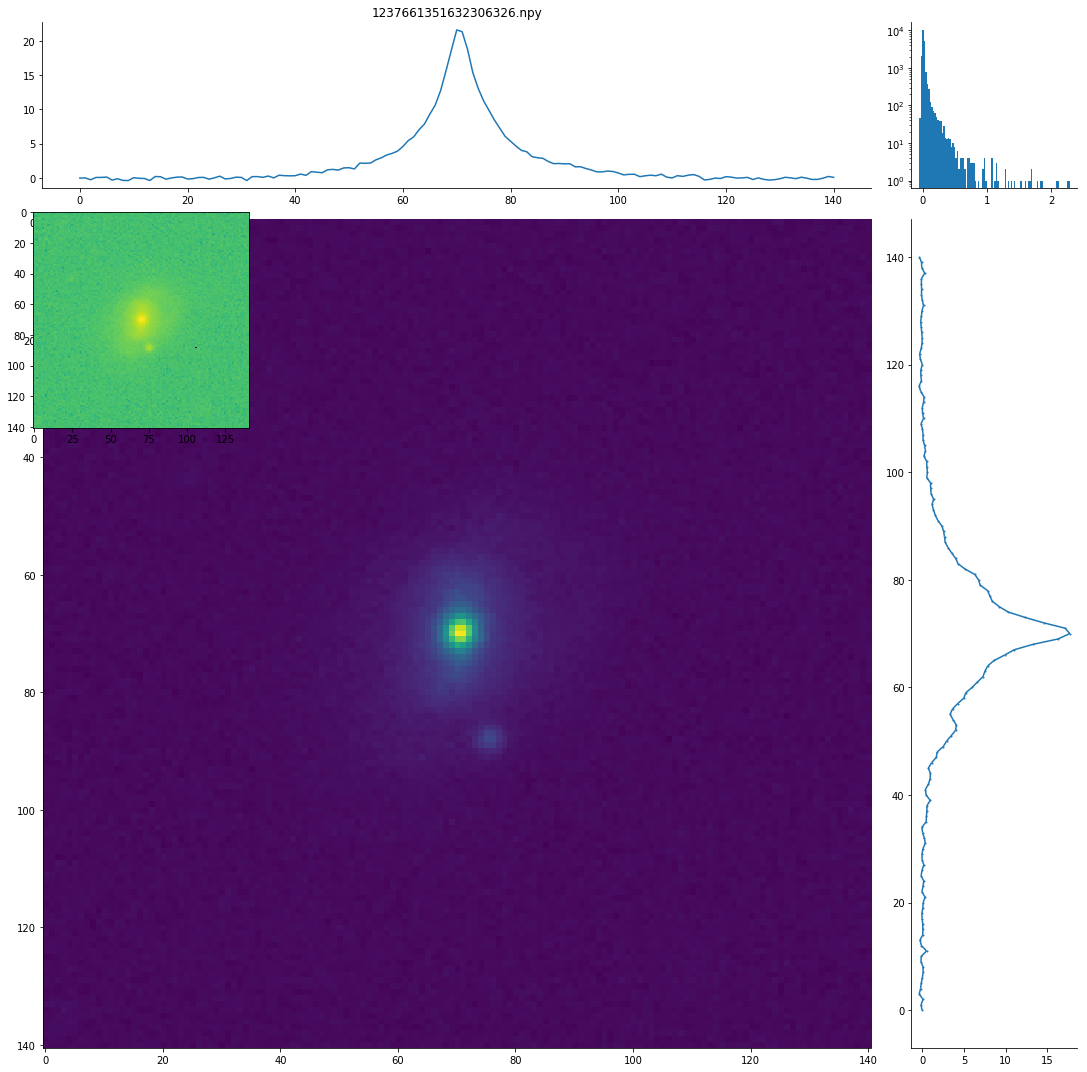

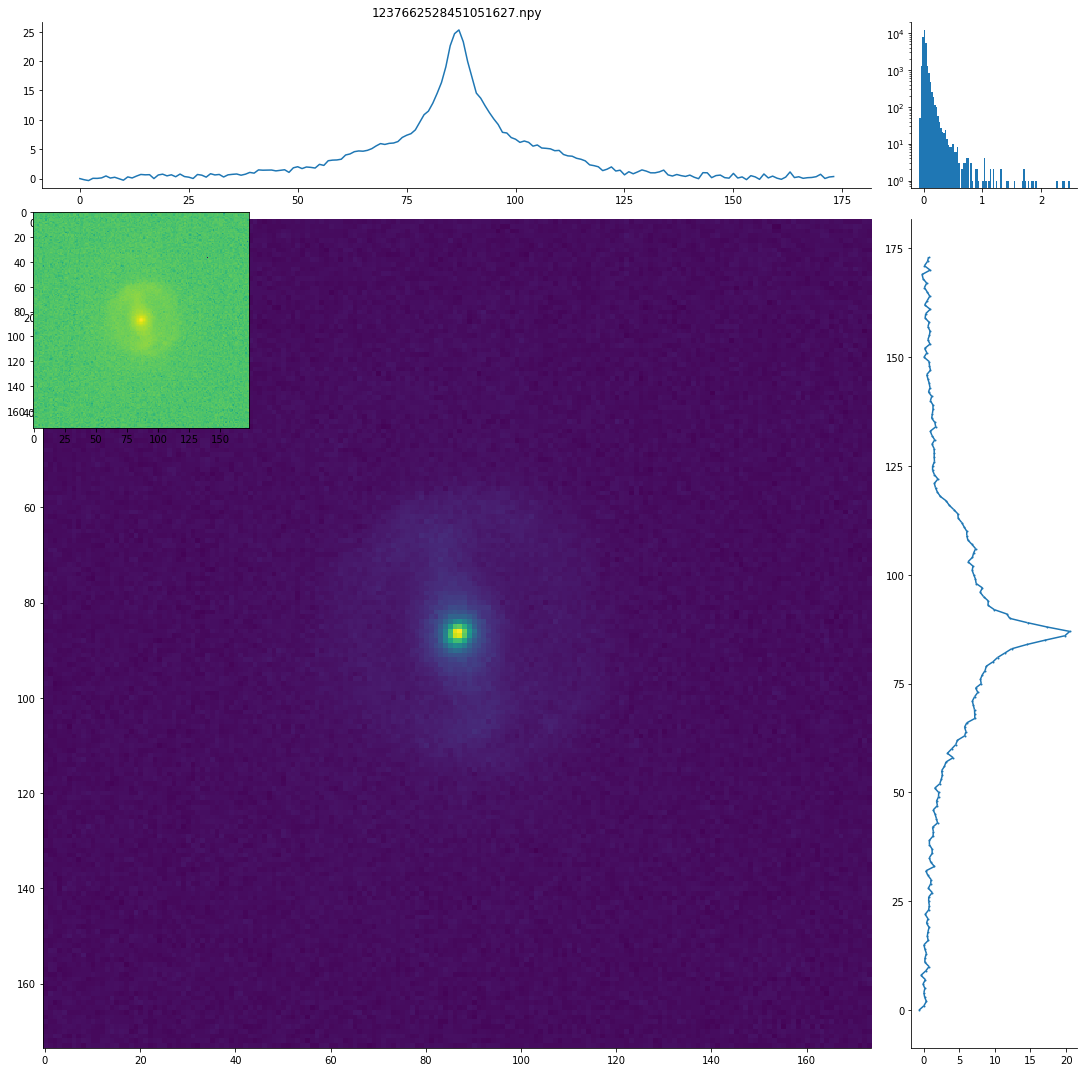

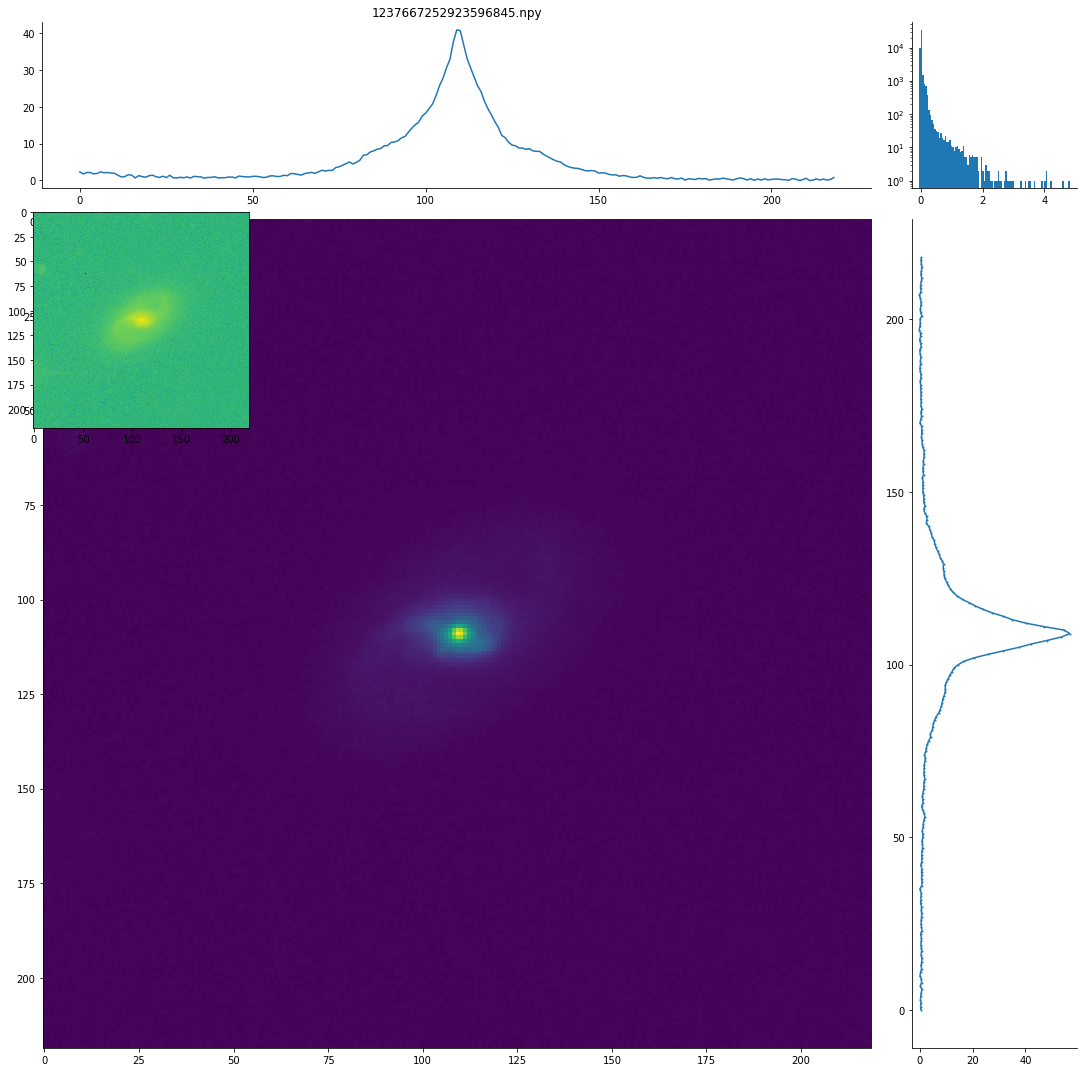

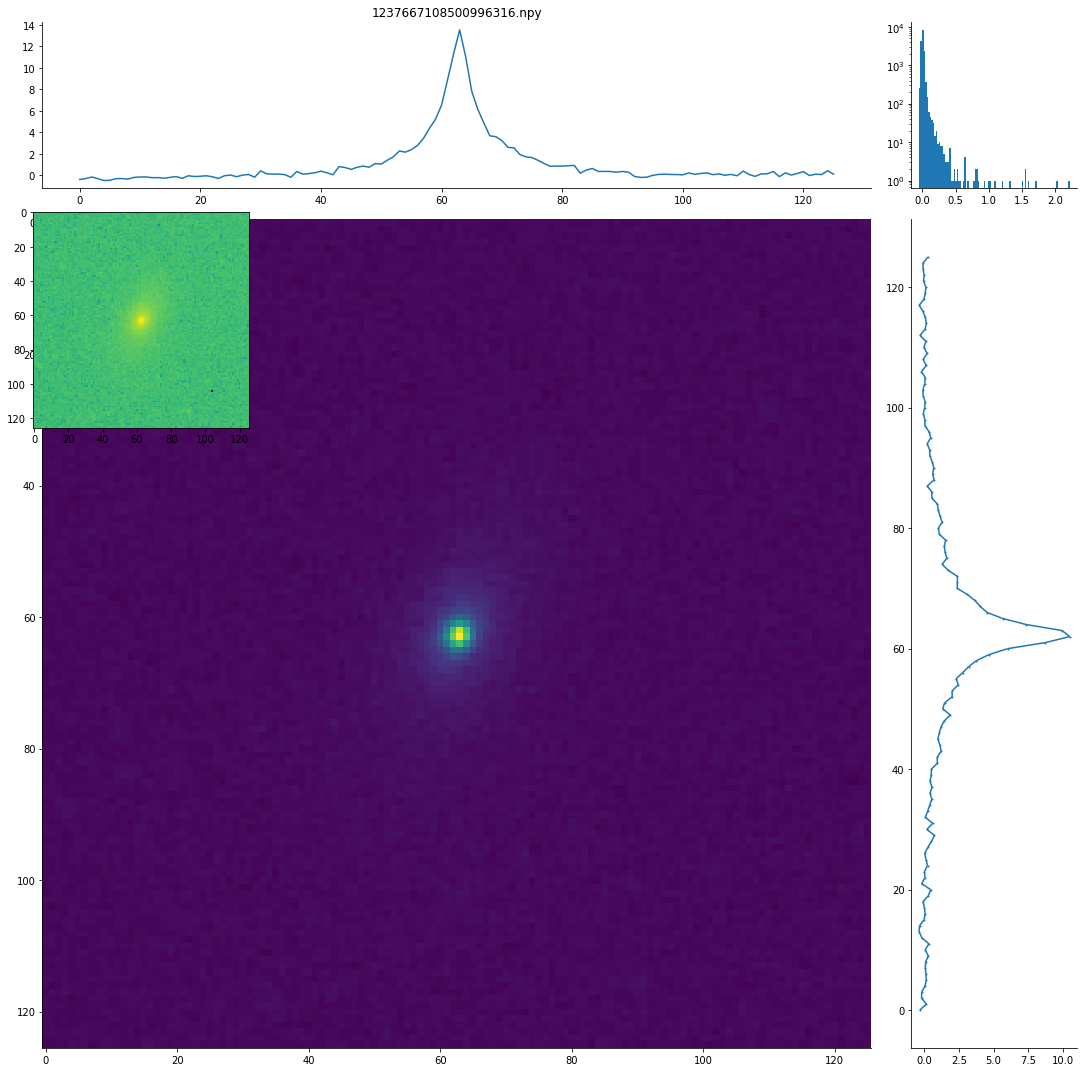

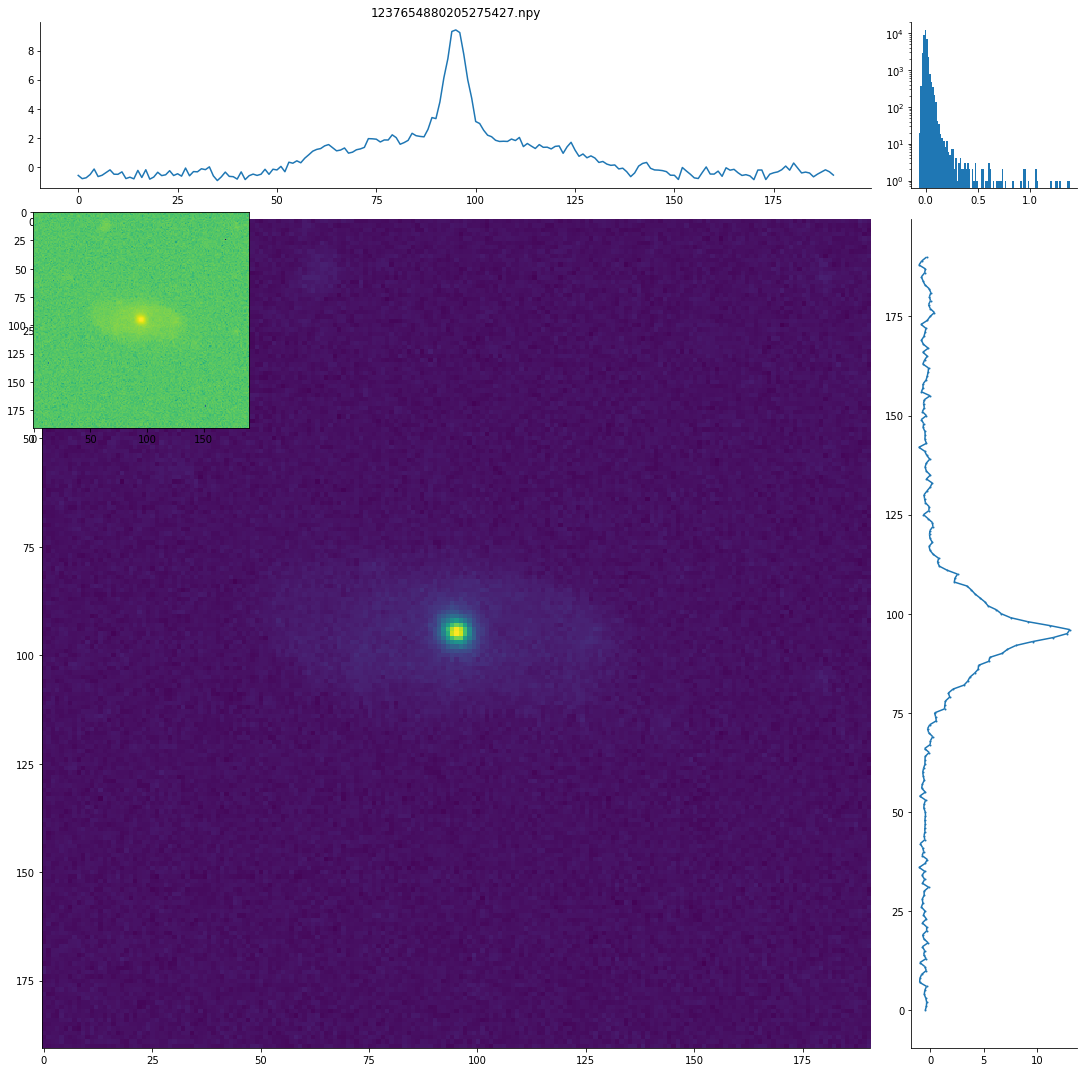

In [7]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
    drawOneGalaxy(dataFileList[i])
    


In [8]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [9]:
print('test')

test


# ML part

In [10]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [11]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*0.75), int(cx*0.75) # crop a bit around center
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg):
#    Xg = cleanupImage(id)
    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id):
    Xg = read_image(id)
    return img_preprocnoread(Xg)

runNameParams.append('ReadLog1pNormCrop.75')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


-1.54381 16.7391
[[-0.06023906 -0.14217247 -0.24313372 -0.28166988 -0.18334472]
 [ 0.08871371 -0.13150845 -0.38808367 -0.40291986 -0.37074235]
 [ 0.25177321 -0.11849967 -0.53693497 -0.48411912 -0.50285965]
 [ 0.19891876 -0.11427473 -0.42654324 -0.13189173  0.00180475]
 [ 0.17769836 -0.16788864 -0.49040389 -0.03297004  0.11308586]]


1

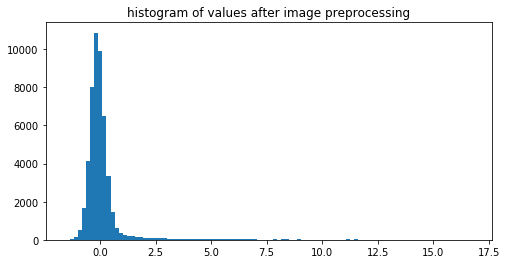

In [12]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [13]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [14]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [15]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [16]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [17]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,185.303775,25.672447,0.557644,0.058701,38.101843,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,57.111612,18.944782,0.194465,0.032567,19.838329,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.486425,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.979375,40.093400,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [18]:
random.seed(42)

df = df.sample(frac=1).reset_index(drop=True)

In [19]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
0,1237651737370558577,186.86505,3.30211,0.851138,0.0488,51.780847,209.14285310677118,0.405581,11.164,0.027,209.142853,1.458814e+11,9.069419e+09,True
1,1237662198287695955,236.91135,6.98296,0.407380,0.1347,68.409583,577.285715511867,1.119504,11.375,0.021,577.285716,2.371374e+11,1.146661e+10,True
2,1237661064950513975,143.53665,9.33690,0.426580,0.0780,41.480496,334.2857211828232,0.648265,10.065,0.041,334.285721,1.161449e+10,1.096477e+09,True
3,1237656567045685347,329.34870,-1.07709,0.724436,0.0540,48.768918,231.42857743161065,0.448799,10.714,0.017,231.428577,5.176068e+10,2.026117e+09,True
4,1237664668981198972,181.29660,40.24726,0.794328,0.0208,20.597411,89.14285738553319,0.172871,9.451,0.066,89.142857,2.824880e+09,4.292988e+08,True


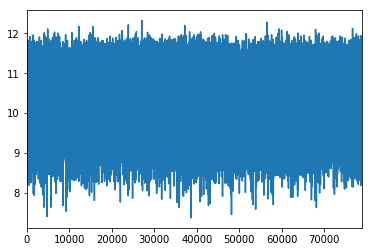

In [20]:
df.logMstar.plot()

In [21]:
print(len(df.SDSS_ID.values))

78851


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [22]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)
prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

chunkSize = 500
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


In [23]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [24]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

78851
70965
500
sp-newSource-ReadLog1pNormCrop.75


In [25]:
# crap instruction to make the auto execution stop here :p

### call img_preproc on all images, per batches of "chunkSize"
### Generate features based on the preprocessed images, pretrained networks and flux densities

In [26]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [27]:
reloadImagesAndPreprocess = 0
maxChunkNumber = math.ceil(len(ids)/chunkSize)

Xg3r50 = []
Xg3vgg16 = []
postImgFeatures = []
csize=2
preImgFeatures = []

chunkStart = 0
# for chunkStart in tqdm(range(0, 3)):
for chunkStart in tqdm(range(0, len(ids), chunkSize)):
    curChunk = int((chunkStart//chunkSize))
    valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

    Xg_ = []
    pre_ex_ = []

    # preprocess the image and collect some raw image stats
    for i in range(chunkStart, chunkStart+valuesInThisChunk):
        X = read_image(ids[i])
        Xg_.append(img_preprocnoread(X))
        pre_ex_.append([
            X.sum(),
            X.min(),
            X.max(),
            X.mean(),
            X.std(),
            X[X.shape[0]//2,X.shape[1]//2],
            np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
            X.shape[0], 
        ])

    # reformat the postprocessing
    pre_ex = np.stack(pre_ex_)
    Xg = np.stack(Xg_)

    # collect some post processing stats
    post_ex = np.hstack([
        np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
        np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
        ])

    Xg3 = np.zeros((valuesInThisChunk,224,224,3))
    Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)
    
    # do r50 prediction
    Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
    Xg3vgg16_ = vgg16.predict(Xg3)


    if chunkStart == 0:
        Xg3r50 = Xg3r50_
        Xg3vgg16 = Xg3vgg16_
        preImgFeatures = pre_ex
        postImgFeatures = post_ex
    else:
        Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
        Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
        preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
        postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)
        
print('done')

postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']



100%|██████████| 158/158 [10:51<00:00,  3.99s/it]

done


In [28]:
Xg3 = None
Xg = None
X = None


In [29]:
Distance = df.Distance.values[:N].reshape(N,1)

Xg3f = np.hstack ( ( 
        Xg3r50, 
        Xg3vgg16, 
        Distance,
        1/Distance,
        Distance**2,
        1/(Distance**2),
        Distance**3,
        1/(Distance**3),
        np.log(Distance),
        1/np.log(Distance),
        np.log(Distance**2),
        1/np.log(Distance**2),
        np.log(Distance)**2,
        1/np.log(Distance)**2,
        preImgFeatures,
        postImgFeatures
        ) )

distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]

In [30]:
prefixThisRound = prefixThisRound + '-model5'

In [31]:
# extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']

Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
            + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
            + [prefixThisRound+'.'+ n for n in distanceNames]
            + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
            + [prefixThisRound+'.'+ n for n in postImgFeatureNames])

print(len(Xg3fNames), Xg3f.shape)

3075 (78851, 3075)


In [32]:
print(Xg3f.shape)
print(df.shape)

t1 = df.SDSS_ID.values[:N].reshape(N,1)
t2 = Xg3f[:N,:]
t3 = np.concatenate((t1,t2), axis=1)
np.save(prefixThisRound+str(N), t3)
np.save(prefixThisRound+str(N) + 'featurenames', Xg3fNames)
del t1, t2, t3

(78851, 3075)
(78851, 14)


In [33]:

# if os.path.isfile(prefixThisRound +str(N)+'.npy'):
#     t3 = np.load(prefixThisRound+str(N)+'.npy')
#     Xg3fNames = np.load(prefixThisRound+str(N) + 'featurenames' + '.npy', )
# Xg3f = t3[:,1:]
# Xg3f.shape

In [34]:
# Xg3f = t3[:,1:]
# Xg3f.shape

### Generate the train/test datasets for lgbm regression

In [35]:
# N = len(df.SDSS_ID.values)
# M = 4000

# N = 10000
# M = 10000
print(M, N)

70965 78851


In [36]:
dtrain = lgbm.Dataset(Xg3f[:M], label= Y[:M])
dtest = lgbm.Dataset(Xg3f[M:], label= Y[M:])


In [37]:

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [38]:

# num_boost_round = len(bst['rmse-mean'])-1
num_boost_round = 29999
print(num_boost_round)


29999


In [39]:
from sklearn.metrics import *

def lgb_rmsle(y_pred,y_true):
   return 'rmsle', mean_squared_error(np.log1p(y_true.get_label()),np.log1p(y_pred)), False

In [40]:
num_boost_round = 30000

model = lgbm.train(lgbm_params, dtrain, num_boost_round,
                   valid_sets=[dtest], valid_names=['test'], fobj=None, feval=lgb_rmsle, 
                   init_model=None, feature_name='auto', categorical_feature='auto', 
                   early_stopping_rounds=100, evals_result=None, verbose_eval=20, 
                   learning_rates=None, callbacks=None)


Training until validation scores don't improve for 100 rounds.
[20]	test's rmse: 0.561569	test's rmsle: 0.00251387
[40]	test's rmse: 0.491163	test's rmsle: 0.0019332
[60]	test's rmse: 0.434031	test's rmsle: 0.00151509
[80]	test's rmse: 0.387869	test's rmsle: 0.00121208
[100]	test's rmse: 0.350963	test's rmsle: 0.000992445
[120]	test's rmse: 0.321437	test's rmsle: 0.000831756
[140]	test's rmse: 0.297868	test's rmsle: 0.000713176
[160]	test's rmse: 0.279744	test's rmsle: 0.000627803
[180]	test's rmse: 0.265848	test's rmsle: 0.000566104
[200]	test's rmse: 0.254702	test's rmsle: 0.000518861
[220]	test's rmse: 0.245641	test's rmsle: 0.000481856
[240]	test's rmse: 0.238332	test's rmsle: 0.000453031
[260]	test's rmse: 0.232552	test's rmsle: 0.000430904
[280]	test's rmse: 0.227737	test's rmsle: 0.000412981
[300]	test's rmse: 0.223778	test's rmsle: 0.000398576
[320]	test's rmse: 0.2204	test's rmsle: 0.000386582
[340]	test's rmse: 0.217513	test's rmsle: 0.000376465
[360]	test's rmse: 0.215029	te

[3020]	test's rmse: 0.180348	test's rmsle: 0.000259395
[3040]	test's rmse: 0.180319	test's rmsle: 0.00025931
[3060]	test's rmse: 0.180257	test's rmsle: 0.00025914
[3080]	test's rmse: 0.180229	test's rmsle: 0.00025906
[3100]	test's rmse: 0.180203	test's rmsle: 0.000258984
[3120]	test's rmse: 0.180172	test's rmsle: 0.000258897
[3140]	test's rmse: 0.180146	test's rmsle: 0.000258827
[3160]	test's rmse: 0.180097	test's rmsle: 0.000258687
[3180]	test's rmse: 0.180059	test's rmsle: 0.000258586
[3200]	test's rmse: 0.180028	test's rmsle: 0.000258501
[3220]	test's rmse: 0.179993	test's rmsle: 0.0002584
[3240]	test's rmse: 0.179956	test's rmsle: 0.000258296
[3260]	test's rmse: 0.179927	test's rmsle: 0.000258213
[3280]	test's rmse: 0.179892	test's rmsle: 0.000258115
[3300]	test's rmse: 0.179872	test's rmsle: 0.000258058
[3320]	test's rmse: 0.17984	test's rmsle: 0.000257966
[3340]	test's rmse: 0.179814	test's rmsle: 0.000257893
[3360]	test's rmse: 0.179773	test's rmsle: 0.000257774
[3380]	test's rm

[6020]	test's rmse: 0.17701	test's rmsle: 0.000250066
[6040]	test's rmse: 0.177017	test's rmsle: 0.000250087
[6060]	test's rmse: 0.17701	test's rmsle: 0.000250065
[6080]	test's rmse: 0.176996	test's rmsle: 0.00025003
[6100]	test's rmse: 0.176977	test's rmsle: 0.00024998
[6120]	test's rmse: 0.176972	test's rmsle: 0.000249964
[6140]	test's rmse: 0.176968	test's rmsle: 0.000249952
[6160]	test's rmse: 0.176961	test's rmsle: 0.000249933
[6180]	test's rmse: 0.176956	test's rmsle: 0.000249918
[6200]	test's rmse: 0.176947	test's rmsle: 0.000249888
[6220]	test's rmse: 0.176935	test's rmsle: 0.000249855
[6240]	test's rmse: 0.176915	test's rmsle: 0.0002498
[6260]	test's rmse: 0.176914	test's rmsle: 0.000249797
[6280]	test's rmse: 0.176893	test's rmsle: 0.000249737
[6300]	test's rmse: 0.176874	test's rmsle: 0.000249683
[6320]	test's rmse: 0.176858	test's rmsle: 0.000249643
[6340]	test's rmse: 0.176857	test's rmsle: 0.000249642
[6360]	test's rmse: 0.176844	test's rmsle: 0.000249609
[6380]	test's rm

[9020]	test's rmse: 0.175486	test's rmsle: 0.000245848
[9040]	test's rmse: 0.175486	test's rmsle: 0.000245849
[9060]	test's rmse: 0.175481	test's rmsle: 0.000245834
[9080]	test's rmse: 0.175486	test's rmsle: 0.000245847
[9100]	test's rmse: 0.175476	test's rmsle: 0.00024582
[9120]	test's rmse: 0.17547	test's rmsle: 0.000245804
[9140]	test's rmse: 0.175467	test's rmsle: 0.000245795
[9160]	test's rmse: 0.175462	test's rmsle: 0.000245783
[9180]	test's rmse: 0.175448	test's rmsle: 0.000245742
[9200]	test's rmse: 0.175434	test's rmsle: 0.000245706
[9220]	test's rmse: 0.175431	test's rmsle: 0.000245696
[9240]	test's rmse: 0.175427	test's rmsle: 0.000245683
[9260]	test's rmse: 0.175421	test's rmsle: 0.000245669
[9280]	test's rmse: 0.175413	test's rmsle: 0.000245647
[9300]	test's rmse: 0.175411	test's rmsle: 0.000245643
[9320]	test's rmse: 0.175411	test's rmsle: 0.000245644
[9340]	test's rmse: 0.175403	test's rmsle: 0.000245619
[9360]	test's rmse: 0.175393	test's rmsle: 0.000245594
[9380]	test'

[11980]	test's rmse: 0.174657	test's rmsle: 0.00024358
[12000]	test's rmse: 0.17465	test's rmsle: 0.000243562
[12020]	test's rmse: 0.174649	test's rmsle: 0.00024356
[12040]	test's rmse: 0.174642	test's rmsle: 0.000243543
[12060]	test's rmse: 0.174634	test's rmsle: 0.000243521
[12080]	test's rmse: 0.174632	test's rmsle: 0.000243517
[12100]	test's rmse: 0.174625	test's rmsle: 0.000243496
[12120]	test's rmse: 0.17462	test's rmsle: 0.000243484
[12140]	test's rmse: 0.174619	test's rmsle: 0.000243481
[12160]	test's rmse: 0.174616	test's rmsle: 0.000243474
[12180]	test's rmse: 0.174614	test's rmsle: 0.000243466
[12200]	test's rmse: 0.174606	test's rmsle: 0.000243447
[12220]	test's rmse: 0.174599	test's rmsle: 0.000243427
[12240]	test's rmse: 0.174603	test's rmsle: 0.000243437
[12260]	test's rmse: 0.174598	test's rmsle: 0.000243421
[12280]	test's rmse: 0.174593	test's rmsle: 0.000243406
[12300]	test's rmse: 0.174589	test's rmsle: 0.000243395
[12320]	test's rmse: 0.174586	test's rmsle: 0.000243

[14920]	test's rmse: 0.174121	test's rmsle: 0.000242148
[14940]	test's rmse: 0.174119	test's rmsle: 0.000242143
[14960]	test's rmse: 0.17412	test's rmsle: 0.000242148
[14980]	test's rmse: 0.174115	test's rmsle: 0.000242134
[15000]	test's rmse: 0.174115	test's rmsle: 0.000242137
[15020]	test's rmse: 0.174113	test's rmsle: 0.00024213
[15040]	test's rmse: 0.174108	test's rmsle: 0.000242119
[15060]	test's rmse: 0.174108	test's rmsle: 0.000242122
[15080]	test's rmse: 0.174109	test's rmsle: 0.000242124
[15100]	test's rmse: 0.174102	test's rmsle: 0.000242105
[15120]	test's rmse: 0.174092	test's rmsle: 0.000242075
[15140]	test's rmse: 0.174093	test's rmsle: 0.000242081
[15160]	test's rmse: 0.174092	test's rmsle: 0.000242078
[15180]	test's rmse: 0.17409	test's rmsle: 0.000242074
[15200]	test's rmse: 0.174089	test's rmsle: 0.000242073
[15220]	test's rmse: 0.17409	test's rmsle: 0.000242075
[15240]	test's rmse: 0.174084	test's rmsle: 0.000242061
[15260]	test's rmse: 0.174086	test's rmsle: 0.000242

In [41]:
pred = model.predict(Xg3f[M:])

In [42]:
print(Y[M:].shape)
print(pred.shape)

(7886,)
(7886,)


In [43]:
chiSq = xi2(Y[M:],pred,err[M:])
linChiSq = xi2(10**Y[M:],10**pred,err_lin[M:])
print(chiSq)
print(linChiSq)


67.7166648672
72.8108541173


In [44]:
print(N,(M,N-M), prefixThisRound, chiSq, linChiSq)
# 7885 (6308, 1577) sp-newSource-ReadNormCrop.5-model1 65.6004981632 289.265891446
# 78851 (63080, 15771) sp-newSource-ReadNormCrop.5-model1 101.26977686 3634.92854724
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1 84.7537916939 112.786722095
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1-model2 76.9540798979 106.544584929
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.5-model3 64.4120566007 82.1151002172
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 72.2302974915 78.0009050209
# 78851 (70965, 7886) sp-newSource-ReadLog1pCrop.75Norm-model4 74.433987693 104.167079904
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 66.7288440316 76.8328009721
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 65.4574681665 81.7908427327
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 72.7632221466 98.9424959642
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.6-model5 69.4944311297 99.8518732071
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model5 60.9081327724 97.7560407261
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model5 127.514883277 131.550875663
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model5 64.7237350883 99.5606822985
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model5 67.7166648672 72.8108541173

78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model5 67.7166648672 72.8108541173


In [45]:
# investigateIDOffset = 2815

# df.loc[M+investigateIDOffset,:]

# print(10**pred[investigateIDOffset]/10**Y[M+investigateIDOffset], 10**Y[M+investigateIDOffset])

# drawOneGalaxy(df.loc[M+investigateIDOffset,'SDSS_ID'])

In [46]:
# def xi2_max(true,pred,error):
#     s=np.argmax((true-pred)**2/error**2)
    
#     plt.hist(np.log(0.00001+(true-pred)**2/error**2),bins=100)
#     return s

In [47]:
# # M = N-4000
# pred[2815] = Y[M+2815]

# print( xi2_max(10**Y[M:],10**pred,err_lin[M:]))


# Same but with Cross Validation

In [48]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [49]:
from sklearn.model_selection import *

In [50]:
# %%time
nSplits = 5
kf = KFold(n_splits=nSplits,shuffle=True, random_state=220673)

ppreds = np.zeros([len(Xg3f),nSplits])
models = []
xis, linxis = [],[]
counter = 0
for tix, vix in kf.split(Xg3f[:M]):
    X_train, X_test = Xg3f[tix], Xg3f[vix]
    Y_train, Y_test = Y[tix], Y[vix]
    
    lgb_train = lgbm.Dataset(X_train, Y_train)
    lgb_eval = lgbm.Dataset(X_test, Y_test)
    
    gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=20000,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100
                    )
    models.append(gbm)
    
    p = gbm.predict(X_test)
    chiSq = xi2(Y_test,p,err[vix])
    linChiSq = xi2(10**Y_test,10**p,err_lin[vix])
    xis.append(chiSq)
    linxis.append(linChiSq)
    print(counter,chiSq,linChiSq)    
    
    ppreds[vix,counter] = p
    counter = counter+1

    
# def lgb_r2(y_pred,y_true):
#    return ‘r2’, r2_score(y_true.get_label(),y_pred), True


# [6:28] 
# gbm.predict(X_test,gbm.best_iteration)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356584	valid_1's rmse: 0.358243
[200]	training's rmse: 0.259152	valid_1's rmse: 0.262462
[300]	training's rmse: 0.226631	valid_1's rmse: 0.231665
[400]	training's rmse: 0.21222	valid_1's rmse: 0.21871
[500]	training's rmse: 0.203411	valid_1's rmse: 0.211281
[600]	training's rmse: 0.196945	valid_1's rmse: 0.206223
[700]	training's rmse: 0.192027	valid_1's rmse: 0.202452
[800]	training's rmse: 0.188074	valid_1's rmse: 0.199672
[900]	training's rmse: 0.18472	valid_1's rmse: 0.197474
[1000]	training's rmse: 0.181805	valid_1's rmse: 0.195693
[1100]	training's rmse: 0.179282	valid_1's rmse: 0.19432
[1200]	training's rmse: 0.176986	valid_1's rmse: 0.193209
[1300]	training's rmse: 0.174951	valid_1's rmse: 0.19227
[1400]	training's rmse: 0.173094	valid_1's rmse: 0.19152
[1500]	training's rmse: 0.17139	valid_1's rmse: 0.190902
[1600]	training's rmse: 0.169802	valid_1's rmse: 0.190363
[1700]	training's rmse: 0

[14100]	training's rmse: 0.0933657	valid_1's rmse: 0.181268
[14200]	training's rmse: 0.0930166	valid_1's rmse: 0.181252
[14300]	training's rmse: 0.0926536	valid_1's rmse: 0.181227
[14400]	training's rmse: 0.0923196	valid_1's rmse: 0.181221
[14500]	training's rmse: 0.0919784	valid_1's rmse: 0.181216
[14600]	training's rmse: 0.0916418	valid_1's rmse: 0.181206
[14700]	training's rmse: 0.0912895	valid_1's rmse: 0.181192
[14800]	training's rmse: 0.0909512	valid_1's rmse: 0.181175
[14900]	training's rmse: 0.0906256	valid_1's rmse: 0.181162
[15000]	training's rmse: 0.0902841	valid_1's rmse: 0.181149
[15100]	training's rmse: 0.0899501	valid_1's rmse: 0.181138
[15200]	training's rmse: 0.0896112	valid_1's rmse: 0.181127
[15300]	training's rmse: 0.0892885	valid_1's rmse: 0.181122
[15400]	training's rmse: 0.0889593	valid_1's rmse: 0.181107
[15500]	training's rmse: 0.0886144	valid_1's rmse: 0.181099
[15600]	training's rmse: 0.0882914	valid_1's rmse: 0.181091
[15700]	training's rmse: 0.0879662	valid

[11700]	training's rmse: 0.102691	valid_1's rmse: 0.177952
[11800]	training's rmse: 0.102287	valid_1's rmse: 0.177933
[11900]	training's rmse: 0.101881	valid_1's rmse: 0.177919
[12000]	training's rmse: 0.101477	valid_1's rmse: 0.177915
[12100]	training's rmse: 0.101086	valid_1's rmse: 0.177898
[12200]	training's rmse: 0.100698	valid_1's rmse: 0.177888
[12300]	training's rmse: 0.10029	valid_1's rmse: 0.177859
[12400]	training's rmse: 0.099888	valid_1's rmse: 0.177839
[12500]	training's rmse: 0.0995035	valid_1's rmse: 0.177821
[12600]	training's rmse: 0.0991139	valid_1's rmse: 0.177801
[12700]	training's rmse: 0.0987165	valid_1's rmse: 0.177778
[12800]	training's rmse: 0.0983327	valid_1's rmse: 0.177763
[12900]	training's rmse: 0.0979509	valid_1's rmse: 0.177739
[13000]	training's rmse: 0.0975558	valid_1's rmse: 0.177724
[13100]	training's rmse: 0.0971839	valid_1's rmse: 0.177703
[13200]	training's rmse: 0.0968093	valid_1's rmse: 0.177685
[13300]	training's rmse: 0.0964432	valid_1's rmse

[8900]	training's rmse: 0.114596	valid_1's rmse: 0.184562
[9000]	training's rmse: 0.114105	valid_1's rmse: 0.184521
[9100]	training's rmse: 0.11365	valid_1's rmse: 0.184498
[9200]	training's rmse: 0.113165	valid_1's rmse: 0.184475
[9300]	training's rmse: 0.112688	valid_1's rmse: 0.184441
[9400]	training's rmse: 0.11222	valid_1's rmse: 0.184413
[9500]	training's rmse: 0.111773	valid_1's rmse: 0.184383
[9600]	training's rmse: 0.111312	valid_1's rmse: 0.18435
[9700]	training's rmse: 0.110856	valid_1's rmse: 0.184328
[9800]	training's rmse: 0.110398	valid_1's rmse: 0.184308
[9900]	training's rmse: 0.109948	valid_1's rmse: 0.184279
[10000]	training's rmse: 0.109495	valid_1's rmse: 0.184251
[10100]	training's rmse: 0.109057	valid_1's rmse: 0.18423
[10200]	training's rmse: 0.108608	valid_1's rmse: 0.18422
[10300]	training's rmse: 0.108175	valid_1's rmse: 0.184198
[10400]	training's rmse: 0.107734	valid_1's rmse: 0.184183
[10500]	training's rmse: 0.107297	valid_1's rmse: 0.184152
[10600]	train

[8200]	training's rmse: 0.118061	valid_1's rmse: 0.183629
[8300]	training's rmse: 0.117549	valid_1's rmse: 0.18359
[8400]	training's rmse: 0.117047	valid_1's rmse: 0.183556
[8500]	training's rmse: 0.116541	valid_1's rmse: 0.183538
[8600]	training's rmse: 0.116048	valid_1's rmse: 0.183496
[8700]	training's rmse: 0.115551	valid_1's rmse: 0.183463
[8800]	training's rmse: 0.11504	valid_1's rmse: 0.183416
[8900]	training's rmse: 0.114554	valid_1's rmse: 0.18337
[9000]	training's rmse: 0.114065	valid_1's rmse: 0.183337
[9100]	training's rmse: 0.113582	valid_1's rmse: 0.183303
[9200]	training's rmse: 0.113115	valid_1's rmse: 0.183261
[9300]	training's rmse: 0.112637	valid_1's rmse: 0.183236
[9400]	training's rmse: 0.11216	valid_1's rmse: 0.183208
[9500]	training's rmse: 0.111692	valid_1's rmse: 0.183172
[9600]	training's rmse: 0.111215	valid_1's rmse: 0.183146
[9700]	training's rmse: 0.110757	valid_1's rmse: 0.183125
[9800]	training's rmse: 0.110299	valid_1's rmse: 0.183105
[9900]	training's 

[9000]	training's rmse: 0.115072	valid_1's rmse: 0.178624
[9100]	training's rmse: 0.114588	valid_1's rmse: 0.178588
[9200]	training's rmse: 0.11411	valid_1's rmse: 0.178559
[9300]	training's rmse: 0.113617	valid_1's rmse: 0.178526
[9400]	training's rmse: 0.113138	valid_1's rmse: 0.178503
[9500]	training's rmse: 0.11266	valid_1's rmse: 0.17847
[9600]	training's rmse: 0.112183	valid_1's rmse: 0.17844
[9700]	training's rmse: 0.111704	valid_1's rmse: 0.178413
[9800]	training's rmse: 0.111239	valid_1's rmse: 0.178387
[9900]	training's rmse: 0.110771	valid_1's rmse: 0.178345
[10000]	training's rmse: 0.110315	valid_1's rmse: 0.178315
[10100]	training's rmse: 0.10986	valid_1's rmse: 0.178285
[10200]	training's rmse: 0.109401	valid_1's rmse: 0.178257
[10300]	training's rmse: 0.108943	valid_1's rmse: 0.178235
[10400]	training's rmse: 0.108494	valid_1's rmse: 0.17821
[10500]	training's rmse: 0.108048	valid_1's rmse: 0.178178
[10600]	training's rmse: 0.107602	valid_1's rmse: 0.178174
[10700]	train

In [51]:
linxis

[118.36675048815718,
 103.17244305219526,
 165.84783979107291,
 2997.4075517812184,
 271.27192433757062]

In [52]:
ppreds = np.zeros([len(models),N-M])
for i, m in zip(range(len(models)),models):
    mp = m.predict(Xg3f[M:])
    ppreds[i] = mp



In [53]:
ppreds.shape

(5, 7886)

In [54]:
cvpred = ppreds.mean(axis=0)

chiSq = xi2(Y[M:],cvpred,err[M:])
linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
print(chiSq)
print(linChiSq)    


65.8956834389
71.960054102


# CV xi² prediction: 71.96

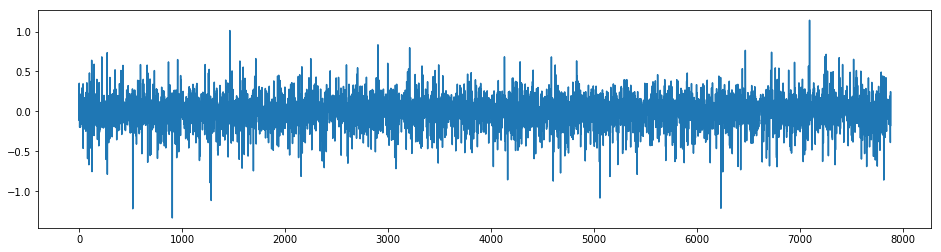

In [55]:
plt.figure(figsize=(16,4))
plt.plot(Y[M:]-cvpred)

10.556
SDSS_ID         1237661387085513201
RA                          255.188
DEC                         27.8275
D25                        0.446684
redshi                       0.0343
GalSize_kpc                 19.1004
D_Mpc             146.9999977520534
d_pix_kpc                   0.28507
logMstar                     10.556
err_logMstar                  0.027
Distance                        147
lin_mass                3.59749e+10
lin_err                 2.23655e+09
hasFile                        True
Name: 906, dtype: object
1237661387085513201


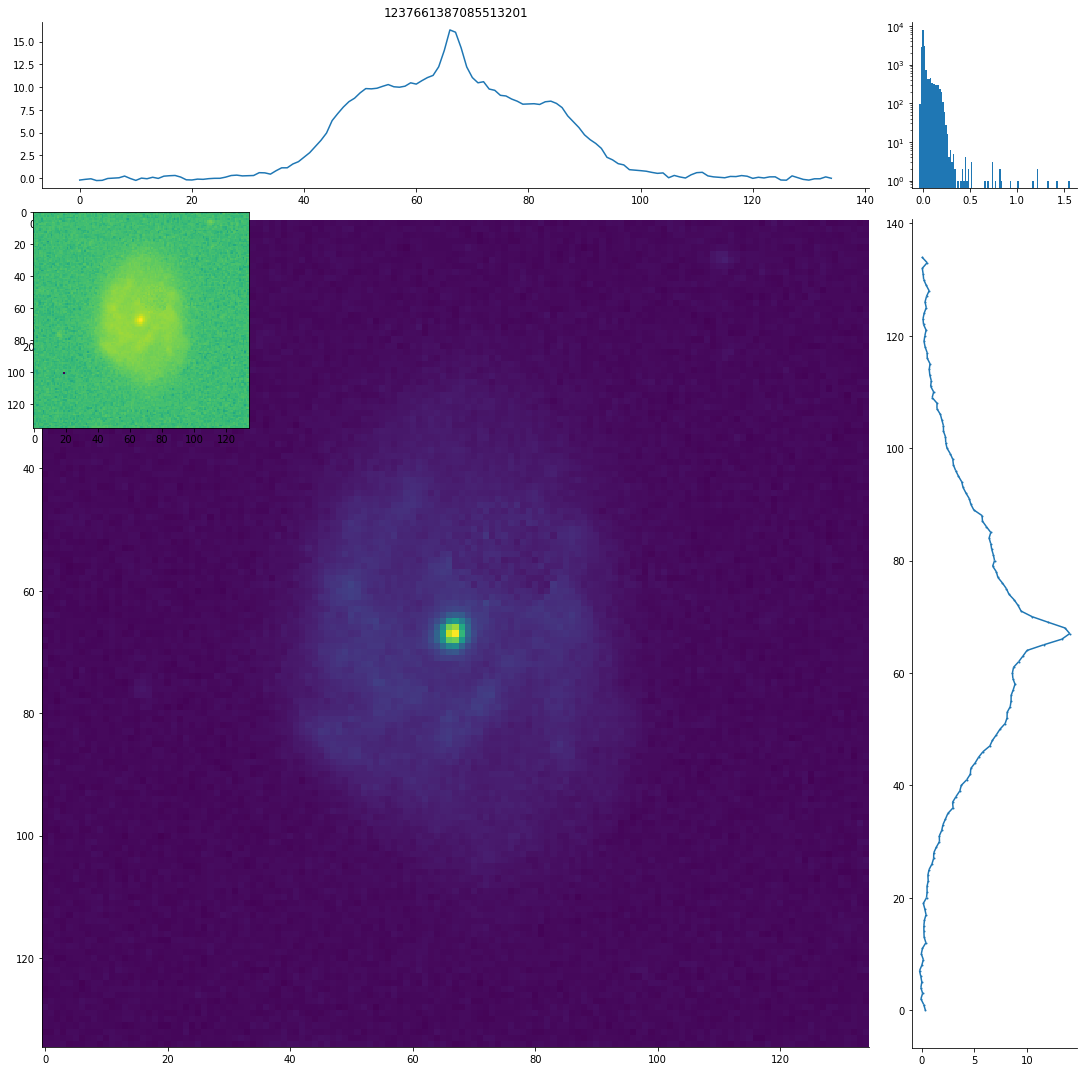

In [59]:
badID = np.argmax(abs(Y[M:]-cvpred))
print(Y[badID])
print(df.loc[badID])
# df['cvpred'] = cvpred
# df['lincvpred'] = 10**cvpred
# df['deltapred'] = abs(Y[M:]-cvpred)
# df['lindeltapred'] = 10**Y[M:]-10**cvpred

drawOneGalaxy(df.SDSS_ID[badID])


In [57]:
print(prefixThisRound)

# df.to_csv(prefixThisRound + '-CVResultDF.csv')

sp-newSource-ReadLog1pNormCrop.75-model5


In [58]:
df.sort_values(by='deltapred', ascending=False).iloc[:20,:]

KeyError: 'deltapred'

In [ ]:
sns.jointplot(x=Y, y=cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y, y=cvpred, kind='resid')
plt.title('log residuals')

sns.jointplot(x=10**Y, y=10**cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=10**Y, y=10**cvpred, kind='resid')
plt.title('log residuals')


# Model is trained, values are obtained, saving and result analysis below

In [ ]:
# break here, save the stuff below

In [ ]:
arr = model.feature_importance()
print(arr.shape)
np.argmax(arr)
# print(arr)

In [ ]:
fimport = list(zip(arr, Xg3fNames))
sorted(fimport, key=lambda x: x[0], reverse=True)[:50]

In [ ]:
sns.jointplot(x=Y[M:], y=pred, kind='kde')
plt.title('log kde')
sns.jointplot(x=Y[M:], y=pred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y[M:], y=pred, kind='resid')
plt.title('log residuals')


sns.jointplot(x=10**Y[M:], y=10**pred, kind='kde')
plt.title('lin kde')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='reg')
plt.title('lin joint')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='resid')
plt.title('lin joint')
# plt.scatter(x=10**Y[M:], y=10**pred)


In [ ]:
df[df['logMstar']>=12]

In [ ]:
print(df.shape)
print(pred.shape)

In [ ]:
plt.plot(10**Y[M:]-10**pred)
worstID = np.argmax(10**Y[M:]-10**pred)

print(Y[M+worstID], pred[worstID])
print(10**Y[M+worstID], 10**pred[worstID])
print(df.loc[M+worstID,:]) # 1237664105244524770, 1237661851469611060 1237654626789163411

# pred[worstID] = Y[M+worstID]

drawOneGalaxy(df.loc[M+worstID,'SDSS_ID'])

In [ ]:
# Warning: predictions from here on will contain data from training set: 
pred = model.predict(Xg3f[:])



In [ ]:
pred.shape

In [ ]:
df['pred'] = pred
df['lin_pred'] = 10**pred

In [ ]:
plt.plot(Y[:]-pred)

In [ ]:
sns.jointplot(data=df, x='lin_pred', y='lin_mass', kind='reg')
plt.title('lin kde')
